# Deep Learning Project - Cats 'n' Dogs

<center>
<img alt="catsNdogs" src="https://i.imgur.com/kBt8k8E.png">
</center>

A deep learning cats and dogs classifier.

**Summary**

---

1. Data

> Our Cats and Dogs Classifier is based on the **[Asirra](https://www.kaggle.com/c/dogs-vs-cats) dataset** (Animal Species Image Recognition for Restricting Access), which is a HIP (Human Interactive Proof) that works by asking users to identify photographs of cats and dogs. We will show that computers can simulate human classification on this dataset reasonably well.

2. Preprocessing

> The images from the dataset were **reshaped** to *(128 x 128) pixel* and **converted** into tensors with the tensorflow *ImageDataGenerator*, that also provided additional training data through **augmentation** *(shifting, flipping, zooming and rotating)*.

3. Model

> We have built a **Convolutional Neural Network** with *MobileNetV2* as convolutional base and *2 additional Dense* layers. The base was partially unfrozen and roughly half of the overall parameters were trained.
>
>```
>_________________________________________________________________
>Layer (type)                 Output Shape              Param #   
>
>=================================================================
>
>mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
>_________________________________________________________________
>global_average_pooling2d (Gl (None, 1280)              0         
>_________________________________________________________________
>flatten (Flatten)            (None, 1280)              0         
>_________________________________________________________________
>dense (Dense)                (None, 512)               655872    
>_________________________________________________________________
>dropout (Dropout)            (None, 512)               0         
>_________________________________________________________________
>dense_1 (Dense)              (None, 2)                 1026      
>
>=================================================================
>
>Total params: 2,914,882
>Trainable params: 1,376,898
>Non-trainable params: 1,537,984
>_________________________________________________________________
>```
>
>The Model was **trained** on **18751** images and **validated** on **6249** images (1:4).

4. Outcome

> Model **Accuracy** (in validation) is approaching **97%**.

<br>
<br>

---

<br>

**Below we will now walk you through the entire process of *exploring* the data, finding the right *model* & *hyperparameters* and *exporting* it.**

## Preparation

Includes **obtaining** the raw data, **exploratory** data anaylsis and **formatting** to a vector form, that's suitable for the model.

### Downloading and Unpacking Files

- Download from Kaggle with Kaggle API
- Unzip
- Split Train into Training and Validation Folders

##### Base Setup for Runtime

In [1]:
%cd /content/drive/My Drive/CoderSchool/DL - Week 7

/content/drive/My Drive/CoderSchool/DL - Week 7


In [0]:
import os
PWD = '/content/drive/My Drive/CoderSchool/DL - Week 7'
os.environ['KAGGLE_CONFIG_DIR'] = PWD

In [0]:
TRAIN_DIR = PWD+'/train/'
VAL_DIR = PWD+'/val/'

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
import random
import datetime
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


warnings.filterwarnings('ignore')
np.random.seed(1)

Using TensorFlow backend.


##### Advanced Setup for Directory

In [0]:
%%capture
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

In [0]:
!kaggle -v

Kaggle API 1.5.6


In [0]:
!kaggle competitions download -c dogs-vs-cats

 99% 807M/812M [00:06<00:00, 139MB/s]
100% 812M/812M [00:06<00:00, 132MB/s]


In [0]:
# Unzip Parent File
from zipfile import ZipFile


file_name = 'dogs-vs-cats.zip'
with ZipFile(file_name) as file:
  print('Unpacking', *file.namelist())
  file.extractall()

Unpacking sampleSubmission.csv test1.zip train.zip


In [0]:
# Unzip Training File
file_name = 'train.zip'
with ZipFile(file_name) as file:
  print('Unpacking', file.namelist())
  file.extractall()

Unpacking ['train/', 'train/cat.0.jpg', 'train/cat.1.jpg', 'train/cat.10.jpg', 'train/cat.100.jpg', 'train/cat.1000.jpg', 'train/cat.10000.jpg', 'train/cat.10001.jpg', 'train/cat.10002.jpg', 'train/cat.10003.jpg', 'train/cat.10004.jpg', 'train/cat.10005.jpg', 'train/cat.10006.jpg', 'train/cat.10007.jpg', 'train/cat.10008.jpg', 'train/cat.10009.jpg', 'train/cat.1001.jpg', 'train/cat.10010.jpg', 'train/cat.10011.jpg', 'train/cat.10012.jpg', 'train/cat.10013.jpg', 'train/cat.10014.jpg', 'train/cat.10015.jpg', 'train/cat.10016.jpg', 'train/cat.10017.jpg', 'train/cat.10018.jpg', 'train/cat.10019.jpg', 'train/cat.1002.jpg', 'train/cat.10020.jpg', 'train/cat.10021.jpg', 'train/cat.10022.jpg', 'train/cat.10023.jpg', 'train/cat.10024.jpg', 'train/cat.10025.jpg', 'train/cat.10026.jpg', 'train/cat.10027.jpg', 'train/cat.10028.jpg', 'train/cat.10029.jpg', 'train/cat.1003.jpg', 'train/cat.10030.jpg', 'train/cat.10031.jpg', 'train/cat.10032.jpg', 'train/cat.10033.jpg', 'train/cat.10034.jpg', 'train/

In [0]:
!mkdir "./train/cat"
!mkdir "./train/dog"
!mkdir "./val"
!mkdir "./val/cat"
!mkdir "./val/dog"

In [0]:
# Fetch all images in the training folder
filenames = [f for f in os.listdir(TRAIN_DIR) if os.path.isfile(TRAIN_DIR+f)]

# Move files into correct folder
for filename in filenames:
  if 'cat' in filename:
    os.replace(TRAIN_DIR+filename, TRAIN_DIR+'cat/'+filename)
  elif 'dog' in filename:
    os.replace(TRAIN_DIR+filename, TRAIN_DIR+'dog/'+filename)

In [0]:
# Choose 25% randomly to the validation set
# Same number of cats and dogs images
for i in range (len(os.listdir(TRAIN_DIR+'cat/'))//4):
  # Move file to val
  # cat
  filename = random.choice(os.listdir(TRAIN_DIR+'cat/'))
  os.replace(TRAIN_DIR+'cat/'+filename, VAL_DIR+'cat/'+filename)
  # dog
  filename = random.choice(os.listdir(TRAIN_DIR+'dog/'))
  os.replace(TRAIN_DIR+'dog/'+filename, VAL_DIR+'dog/'+filename)

### Taking a look at the Data

#### Create DataFrame

We'll create a DataFrame only for exploring our Data. This won't be included in the steps for the final Model and is just for visualizing and easier access.

In [0]:
df = {'image':[], 'label':[], 'size_x':[], 'size_y':[]}

# Cats
filenames = os.listdir(TRAIN_DIR+'cat/')
for filename in filenames:
  df['image'].append(filename)
  df['label'].append(0)
  size_x, size_y = load_img(TRAIN_DIR+'cat/'+filename).size
  df['size_x'].append(size_x)
  df['size_y'].append(size_y)

# Dogs
filenames = os.listdir(TRAIN_DIR+'dog/')
for filename in filenames:
  df['image'].append(filename)
  df['label'].append(1)
  size_x, size_y = load_img(TRAIN_DIR+'dog/'+filename).size
  df['size_x'].append(size_x)
  df['size_y'].append(size_y)

df = pd.DataFrame(df)
df.sample(10)

,image,label,size_x,size_y
9492,dog.9725.jpg,1,499,490
6970,cat.1537.jpg,0,240,159
1882,cat.7857.jpg,0,350,314
13697,dog.4821.jpg,1,499,428
91,cat.9764.jpg,0,500,374
901,cat.916.jpg,0,450,331
9941,dog.9422.jpg,1,500,374
14798,dog.3684.jpg,1,443,380
10121,dog.8818.jpg,1,479,360
15969,dog.1759.jpg,1,399,426


#### Visualize

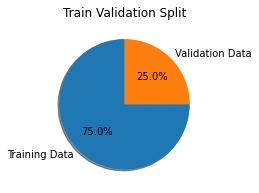

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(5,3), gridspec_kw={'width_ratios': [1], 'wspace':0})

ax.pie([len(df), len(os.listdir(VAL_DIR+'cat/'))+len(os.listdir(VAL_DIR+'dog/'))], labels=['Training Data', 'Validation Data'], autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_title('Train Validation Split')
plt.show()

In [0]:
sample = df.sample()

# Cat 0 or Dog 1
if sample['label'].values[0] == 0:
  sample = TRAIN_DIR+'cats/'+sample['image'].values[0]
else:
  sample = TRAIN_DIR+'dog/'+sample['image'].values[0]
sample

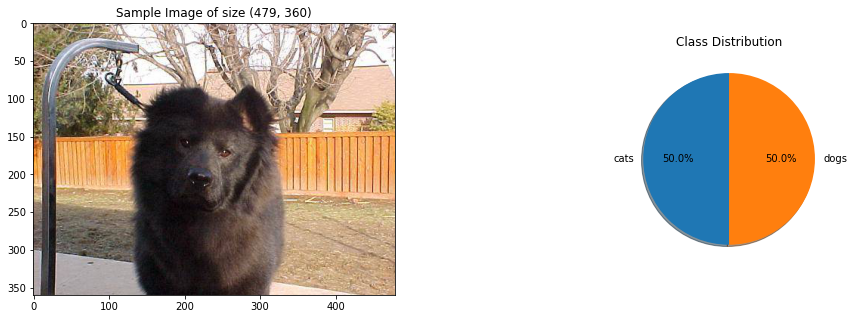

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [2, 1], 'wspace':0.6})

# Frist Row
ax[0].imshow(load_img(sample))
ax[0].set_title('Sample Image of size ' + str(load_img(sample).size))
ax[1].pie([df[df['label']==0]['label'].count(), df[df['label']==1]['label'].count()], labels=['cat', 'dog'], autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].set_title('Class Distribution')
plt.show()

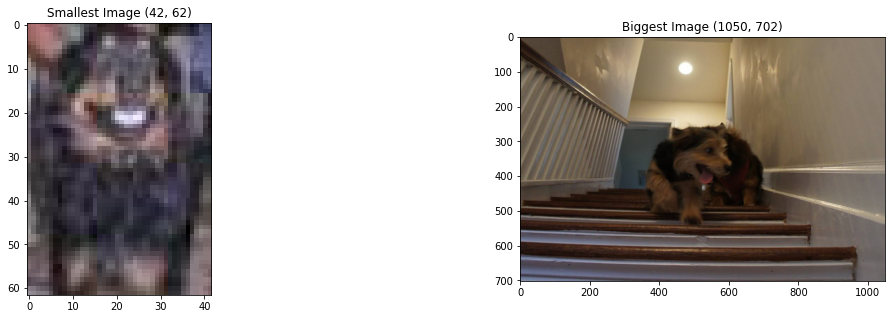

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(17,5), gridspec_kw={'width_ratios': [2, 2], 'wspace':0.6})

smallest = df.sort_values(by=['size_x', 'size_y'])['image'].values[0]
if 'cat' in smallest:
  smallest = TRAIN_DIR + 'cats/' + smallest
elif 'dog' in smallest:
  smallest = TRAIN_DIR + 'dog/' + smallest

biggest = df.sort_values(by=['size_x', 'size_y'], ascending=False)['image'].values[0]
if 'cat' in biggest:
  biggest = TRAIN_DIR + 'cats/' + biggest
elif 'dog' in biggest:
  biggest = TRAIN_DIR + 'dog/' + biggest

ax[0].imshow(load_img(smallest))
ax[0].set_title('Smallest Image ' + str(load_img(smallest).size))
ax[1].imshow(load_img(biggest))
ax[1].set_title('Biggest Image ' + str(load_img(biggest).size))
plt.show()

### Format the data

In [0]:
# Setting Hyperparameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASS_NAMES = np.array(['dog', 'cat'])
NUMBER_TRAIN_IMG = len(os.listdir(TRAIN_DIR+'cat/'))+len(os.listdir(TRAIN_DIR+'dog/'))
NUMBER_VAL_IMG = len(os.listdir(VAL_DIR+'cat/'))+len(os.listdir(VAL_DIR+'dog/'))
EPOCHS = 5

In [0]:
def steps_per_epoch(NUM):
  return tf.math.ceil(NUM/BATCH_SIZE).numpy()

#### With tf.preprocessing

In [0]:
train_datagen = ImageDataGenerator(
  featurewise_center=True,            # Center to around 0
  featurewise_std_normalization=True, # Std to [0,1]
  # Random Augmentation for higher resilience and more training data
  rotation_range=40,                  # randomly rotate between 0-40 deg
  width_shift_range=0.2,              # randomly translate horizontally between 0-20%
  height_shift_range=0.2,             # randomly translate vertically between 0-20%
  shear_range=0.2,                    # randomly shearing (like skewing) between 0-20%
  zoom_range=0.2,                     # randomly zooming in between 0-20%
  horizontal_flip=True,               # randomly flipping 50% of images horizontally
  fill_mode='nearest'                 # fills newly created pixels with the nearest (drags the img out)
  )  

test_datagen = ImageDataGenerator(    
  featurewise_center=True,           # Center to around 0
  featurewise_std_normalization=True # Std to [0,1]
  )

train_generator = train_datagen.flow_from_directory(
  directory=TRAIN_DIR,
  batch_size=BATCH_SIZE,
  shuffle=True,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  class_mode='binary'
  )

val_generator = test_datagen.flow_from_directory(
  directory=VAL_DIR,
  batch_size=BATCH_SIZE,
  shuffle=True,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  class_mode='binary'
  )

Found 18751 images belonging to 2 classes.
Found 6249 images belonging to 2 classes.


In [0]:
sample = '/content/drive/My Drive/CoderSchool/DL - Week 7/train/dog/dog.9422.jpg'

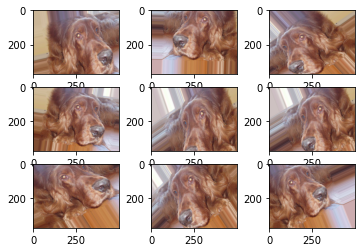

In [0]:
# load the image
img = load_img(sample)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
# prepare iterator
it = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

#### With tf.Data
The ImageDataGenerator was convenient, but **slow** and **doesn't give us a Tensor** to work with, so we'll build a Dataset as well.

In [0]:
train_generator is tf.Tensor

False

In [0]:
# Build Dataset
ds_train = tf.data.Dataset.list_files(TRAIN_DIR+'**/*',  shuffle=True, seed=0)
ds_val = tf.data.Dataset.list_files(VAL_DIR+'**/*',  shuffle=True, seed=0)

In [0]:
for f in list_ds_train.take(3):
  print(f.numpy())
for f in list_ds_val.take(3):
  print(f.numpy())

b'/content/drive/My Drive/CoderSchool/DL - Week 7/train/dogs/dog.1328.jpg'
b'/content/drive/My Drive/CoderSchool/DL - Week 7/train/dogs/dog.11474.jpg'
b'/content/drive/My Drive/CoderSchool/DL - Week 7/train/cats/cat.3860.jpg'
b'/content/drive/My Drive/CoderSchool/DL - Week 7/val/dogs/dog.2749.jpg'
b'/content/drive/My Drive/CoderSchool/DL - Week 7/val/cats/cat.4608.jpg'
b'/content/drive/My Drive/CoderSchool/DL - Week 7/val/dogs/dog.1245.jpg'


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
ds_train = ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
for image, label in ds_train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
for image, label in ds_val.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  [False  True]
Image shape:  (256, 256, 3)
Label:  [ True False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
ds_train = prepare_for_training(ds_train)
ds_val = prepare_for_training(ds_val)

image_batch, label_batch = next(iter(ds_train))
#image_batch, label_batch = next(iter(ds_val))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

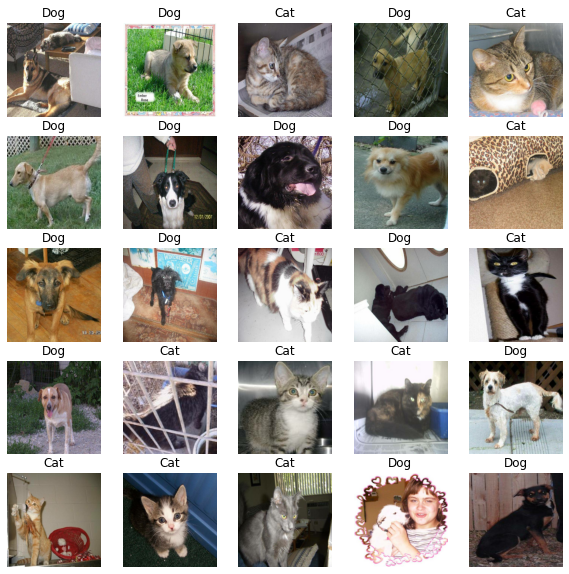

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Create the Model

### Experimental Models

To find the best approach for our final model, we will experiment with the following tweaks:

- Basic Keras Model with a minimum of layers
- Advanced Keras Model with more layers and a Base Model
- Deeper and shallower Image Data Generators
- Different Optimizers (Adam, Nadam)

In [0]:
# Set Epochs lower for experimenting with the hyperparameters
EXPERIMENT_EPOCH = 1

#### Basic Keras model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=IMG_SHAPE),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 19,267,970
Trainable params: 19,267,970
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpoint_path = PWD+'/training_0/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch(NUMBER_TRAIN_IMG),
    epochs=EXPERIMENT_EPOCH,
    validation_data=val_generator,
    validation_steps=steps_per_epoch(NUMBER_VAL_IMG),
    callbacks=[cp_callback],
    verbose=1,
    workers=4
)

586/586 [==============================] - ETA: 0s - loss: 916.1129 - accuracy: 0.5155
Epoch 00001: saving model to /content/drive/My Drive/CoderSchool/DL - Week 7/training_0/cp.ckpt
586/586 [==============================] - 2674s 5s/step - loss: 916.1129 - accuracy: 0.5155 - val_loss: 643.0869 - val_accuracy: 0.5170


#### Transfer learning with MobileNetV2
Let's see what we can do with a MobileNetV2 (frozen) Base.

In [0]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable=False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation = 'softmax')])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
checkpoint_path = PWD+'/training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch(NUMBER_TRAIN_IMG),
    epochs=EXPERIMENT_EPOCH,
    validation_data=val_generator,
    validation_steps=steps_per_epoch(NUMBER_VAL_IMG),
    callbacks=[cp_callback],
    verbose=1,
    workers=8,
)

Epoch 1/10
586/586 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.6428
Epoch 00001: saving model to /content/drive/My Drive/CoderSchool/DL - Week 7/training_1/cp.ckpt
586/586 [==============================] - 2687s 5s/step - loss: 0.6393 - accuracy: 0.6428 - val_loss: 0.7319 - val_accuracy: 0.5835
Epoch 2/10
586/586 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.6744
Epoch 00002: saving model to /content/drive/My Drive/CoderSchool/DL - Week 7/training_1/cp.ckpt
586/586 [==============================] - 1049s 2s/step - loss: 0.6023 - accuracy: 0.6744 - val_loss: 0.6041 - val_accuracy: 0.6670
Epoch 3/10
586/586 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.6822
Epoch 00003: saving model to /content/drive/My Drive/CoderSchool/DL - Week 7/training_1/cp.ckpt
586/586 [==============================] - 1056s 2s/step - loss: 0.5921 - accuracy: 0.6822 - val_loss: 0.5613 - val_accuracy: 0.7065
Epoch 4/10
586/586 [=====

#### Advanced Keras Model

The **Basic Model overfits** our data, because we have a lot of Input Parameters and thus a very wide, but shallow model. We have to remember that shallow networks are very good at memorization, but not so good at generalization. <br>
Let's try to fix this with a **deeper** model and a **decreased** number of **parameters**.



###### New smaller generators

In [0]:
# Setting Hyperparameters
BATCH_SIZE = 32
IMG_HEIGHT = 56                                 # NOW: Smaller images
IMG_WIDTH = 56                                  # NOW: Smaller images
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASS_NAMES = np.array(['dog', 'cat'])
NUMBER_TRAIN_IMG = len(os.listdir(TRAIN_DIR+'cat/'))+len(os.listdir(TRAIN_DIR+'dog/'))
NUMBER_VAL_IMG = len(os.listdir(VAL_DIR+'cat/'))+len(os.listdir(VAL_DIR+'dog/'))
EPOCHS = 5

In [0]:
train_datagen = ImageDataGenerator(
  rescale=1./255,             # Scale
  # Random Augmentation for higher resilience and more training data
  horizontal_flip=True,       # randomly flipping 50% of images horizontally
  )  

test_datagen = ImageDataGenerator(    
  rescale=1./255,
  )

train_generator = train_datagen.flow_from_directory(
  directory=TRAIN_DIR,
  batch_size=BATCH_SIZE,
  shuffle=True,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  class_mode='binary'
  )

val_generator = test_datagen.flow_from_directory(
  directory=VAL_DIR,
  batch_size=BATCH_SIZE,
  shuffle=True,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  class_mode='binary'
  )

Found 18751 images belonging to 2 classes.
Found 6249 images belonging to 2 classes.


###### sequential & training

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32,                              # filter: dimensionality of the output space
                         (3, 3),                          # kernel size: length of the 1D convolution window
                         activation='relu', 
                         input_shape=IMG_SHAPE
                         ),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),         # down-sample
  tf.keras.layers.Dropout(0.25),                          # ignore for improved resilience

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(2, activation='softmax')          # Output ['Dog', 'Cat']
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 54, 54, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 27, 27, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 10, 128)      

In [0]:
checkpoint_path = PWD+'/training_2/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch(NUMBER_TRAIN_IMG),
    epochs=EXPERIMENT_EPOCH,
    validation_data=val_generator,
    validation_steps=steps_per_epoch(NUMBER_VAL_IMG),
    callbacks=[cp_callback],
    verbose=1,
    workers=4
)

586/586 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.6142
Epoch 00001: saving model to /content/drive/My Drive/CoderSchool/DL - Week 7/training_2/cp.ckpt
586/586 [==============================] - 206s 352ms/step - loss: 0.6505 - accuracy: 0.6142 - val_loss: 0.5958 - val_accuracy: 0.6928


##### Check a different Compilation

*Adaptive Moment Estimation* (**Adam**) utilizes an exponentially decaying average of both past gradients and past squared gradients to estimate first and second moments of the gradients. This allows Adam to effectively compute adaptive learning rates for each parameter.

*Nesterov-accelerated Adaptive Moment Estimation* (**Nadam**) incorporates Nesterov momentum, which is at times superior to vanilla momentum, into the Adam algorithm.

###### Same Advanced Model

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32,                              # filter: dimensionality of the output space
                         (3, 3),                          # kernel size: length of the 1D convolution window
                         activation='relu', 
                         input_shape=IMG_SHAPE
                         ),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),         # down-sample
  tf.keras.layers.Dropout(0.25),                          # ignore for improved resilience

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(2, activation='softmax')          # Output ['Dog', 'Cat']
])

###### Different Compilation

In [0]:
model.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [0]:
checkpoint_path = PWD+'/training_3/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch(NUMBER_TRAIN_IMG),
    epochs=EXPERIMENT_EPOCH,
    validation_data=val_generator,
    validation_steps=steps_per_epoch(NUMBER_VAL_IMG),
    callbacks=[cp_callback],
    verbose=1,
    workers=4
)

586/586 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.6379
Epoch 00001: saving model to /content/drive/My Drive/CoderSchool/DL - Week 7/training_3/cp.ckpt
586/586 [==============================] - 206s 351ms/step - loss: 0.6384 - accuracy: 0.6379 - val_loss: 0.5803 - val_accuracy: 0.7168


#### Transfer learning with EfficientNet-B3

[Efficient Net](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet) can be an improvement over MobileNetV2

In [0]:
# Import Checkpoints from Github

### Combining the insights to a final Model

##### New medium sized generators

In [0]:
# Setting Hyperparameters
BATCH_SIZE = 32
IMG_HEIGHT = 128                                 # NOW: Medium images
IMG_WIDTH = 128                                  # NOW: Medium images
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASS_NAMES = np.array(['dog', 'cat'])
NUMBER_TRAIN_IMG = len(os.listdir(TRAIN_DIR+'cat/'))+len(os.listdir(TRAIN_DIR+'dog/'))
NUMBER_VAL_IMG = len(os.listdir(VAL_DIR+'cat/'))+len(os.listdir(VAL_DIR+'dog/'))
EPOCHS = 10

In [0]:
def steps_per_epoch(NUM):
  return tf.math.ceil(NUM/BATCH_SIZE).numpy()

In [11]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  # Random Augmentation for higher resilience and more training data
  rotation_range=40,                  # randomly rotate between 0-40 deg
  width_shift_range=0.2,              # randomly translate horizontally between 0-20%
  height_shift_range=0.2,             # randomly translate vertically between 0-20%
  zoom_range=0.2,                     # randomly zooming in between 0-20%
  horizontal_flip=True,               # randomly flipping 50% of images horizontally
  fill_mode='nearest'                 # fills newly created pixels with the nearest (drags the img out)
  )  

test_datagen = ImageDataGenerator(    
  rescale=1./255
  )

train_generator = train_datagen.flow_from_directory(
  directory=TRAIN_DIR,
  batch_size=BATCH_SIZE,
  shuffle=True,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  class_mode='binary'
  )

val_generator = test_datagen.flow_from_directory(
  directory=VAL_DIR,
  batch_size=BATCH_SIZE,
  shuffle=True,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  class_mode='binary'
  )

Found 18751 images belonging to 2 classes.
Found 6249 images belonging to 2 classes.


##### New Base Model

In [0]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, # Shape changed compared to prior base model
                                               include_top=False,
                                               weights='imagenet')

In [0]:
# Unfreeze ( instead of inserting own Convolutional Layers)
base_model.trainable = True

In [14]:
# How many layers are there?
len(base_model.layers)

155

In [0]:
# Fine-tune only 5 layers (like in our Advanced Keras Model)
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

##### Final Model

###### Build Sequence

In [0]:
model = tf.keras.Sequential([
  # MobileNetV2 Model
  base_model,
  # input from base to any size
  tf.keras.layers.GlobalAveragePooling2D(),                 # by taking the average of every incoming feature map

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(2, activation='softmax')            # Output ['Dog', 'Cat']
])

###### Compile

In [0]:
model.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 2,914,882
Trainable params: 1,376,898
Non-trainable params: 1,537,984
______________________________________

###### Add Callbacks

In [0]:
# Checkpoints
checkpoint_path = PWD+'/training_5/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
# Early Stoppage
es_callback = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',           # What do we measure
                min_delta=0,                  # What's considered a change
                patience=2,                   # How many epochs to wait after no change occured
                verbose=1, 
                mode='auto',                  # Rising or Falling
                baseline=None,                # Minimum monitor value for training
                restore_best_weights=True     # Pick the best weights
              )

In [0]:
# Learning Rate Scheduler
# learning rate start at 0.001 --> decrease exponentially after 3 epochs
def schedule(epoch):
  if epoch < 3:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (3 - epoch))

In [0]:
lrs_callback = tf.keras.callbacks.LearningRateScheduler(
                schedule, verbose=1
              )

In [0]:
# TensorBoard
%load_ext tensorboard

In [0]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

###### Train

In [29]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch(NUMBER_TRAIN_IMG),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=steps_per_epoch(NUMBER_VAL_IMG),
    callbacks=[cp_callback, es_callback, lrs_callback, tb_callback],
    verbose=1,
    workers=4
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/10
586/586 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.9188
Epoch 00001: saving model to /content/drive/My Drive/CoderSchool/DL - Week 7/training_5/cp.ckpt
586/586 [==============================] - 448s 764ms/step - loss: 0.3920 - accuracy: 0.9188 - val_loss: 0.3647 - val_accuracy: 0.9482 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/10
586/586 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.9209
Epoch 00002: saving model to /content/drive/My Drive/CoderSchool/DL - Week 7/training_5/cp.ckpt
586/586 [==============================] - 452s 772ms/step - loss: 0.3888 - accuracy: 0.9209 - val_loss: 0.3518 - val_accuracy: 0.9603 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/10
586/586 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.9305
Epoch 00003: savi

###### Monitor Training

In [0]:
%tensorboard --logdir logs

###### Test Prediction

In [0]:
def predict(image_path):    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
        rescale=1./255
        )
        
    # load the image
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    # convert to numpy array
    image = tf.keras.preprocessing.image.img_to_array(image)
    # expand dimension to one sample
    image = np.expand_dims(image, 0)
    # prepare iterator
    image = test_datagen.flow(image, batch_size=1)[0]

    # load model
    model = tf.keras.models.load_model('saved_model/catsNdogs_combined')
    # predict
    return model.predict(image, verbose=1)[0]


In [6]:
images = [VAL_DIR+f'cat/cat.{i}.jpg' for i in [9997, 9993, 9986, 9985, 9984]]
for i in [9992, 9991, 9980, 999]:
  images.append(VAL_DIR+f'dog/dog.{i}.jpg')
print(images)

['/content/drive/My Drive/CoderSchool/DL - Week 7/val/cat/cat.9997.jpg', '/content/drive/My Drive/CoderSchool/DL - Week 7/val/cat/cat.9993.jpg', '/content/drive/My Drive/CoderSchool/DL - Week 7/val/cat/cat.9986.jpg', '/content/drive/My Drive/CoderSchool/DL - Week 7/val/cat/cat.9985.jpg', '/content/drive/My Drive/CoderSchool/DL - Week 7/val/cat/cat.9984.jpg', '/content/drive/My Drive/CoderSchool/DL - Week 7/val/dog/dog.9992.jpg', '/content/drive/My Drive/CoderSchool/DL - Week 7/val/dog/dog.9991.jpg', '/content/drive/My Drive/CoderSchool/DL - Week 7/val/dog/dog.9980.jpg', '/content/drive/My Drive/CoderSchool/DL - Week 7/val/dog/dog.999.jpg']


In [0]:
def prediction_label(image):
  p = predict(image)
  if p[0] > p[1]:
    return 'Cat: ' + str(p)
  else:
    return 'Dog: ' + str(p)

1/1 [==============================] - 0s 2ms/step


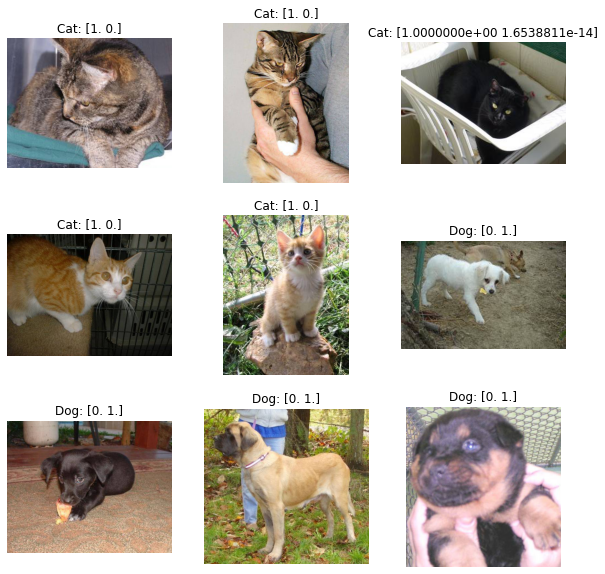

In [8]:
plt.figure(figsize=(10,10))
for n in range(9):
  try:
    ax = plt.subplot(3,3,n+1)
    plt.imshow(tf.keras.preprocessing.image.load_img(images[n]))
    plt.title(prediction_label(images[n]))
    plt.axis('off')
  except FileNotFoundError:
    continue

##### Save the model for Deployment

In [0]:
# Prepare saving step
!mkdir -p saved_model

In [30]:
model.save('saved_model/catsNdogs_combined') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/catsNdogs_combined/assets


## Outlook

Even though the accuracy is sufficient for the use in a MVP, future improvements have to be made to ensure computational efficiency as well as stability and reliability of the predictions.

- Using **multiple workers** should be implemented with a Strategy (e.g. *MultiWorkerMirroredStrategy*) for better performance and accuracy. 
- **Hyperparameters** should be set **programmatically** and monitored more closely, instead of this Trial and Error approach for a first Draft.
This is especially interesting for the Data Augementation Part.
- Callbacks (**LRS**, **ES**) should be modified for a longer learning (more epochs) as soon as there are enough computational resources available.
- The **testing set** was held out completely, but only used for the final product in **minimal capacity**. Future improvements could look at redistribution of the whole data to rearrange and provide more training data. 